# Experiments on the DAME and FLAME algorithms

The `DAME-FLAME` package provides fast, large-scale, and high-quality interpretable matches in causal inference. This document serves to illustrate ways in which this package provides higher quality matches than the matches given by Propensity Score matching.

This code was written by Neha Gupta, with some data generating and visualization code copied from Yameng Liu, Awa Dieng and Tianyu Wang. For questions on this code, or on the DAME-FLAME Python Package, please contact Neha at neha.r.gupta "at" duke "dot" edu. 

In [1]:
import numpy as np
import pandas as pd
import dame_flame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import rpy2.robjects as robjects
import rpy2.robjects.packages
from rpy2.robjects.packages import importr

## First, we generate the data. 

The outcome is generated with 

$$ y=\sum_{i}\alpha_{i}x_{i}+T\sum_{i}\beta_{i}x_{i}+T\sum_{i,\gamma,\gamma>i}x_{i}x_{\gamma} $$

Each of the terms $y, x_i, \alpha_i, \beta_i$ is of size 1xn where n is the total number of units, 30000 in this case. Also, the i is the number of covariates, which is 18 in this case. 

$T\in\{0,1\}$ is the binary treatment indicator. 

In this document, we choose each unit, $x_{in}$ from a Bernoulli distribution with parameter 0.5. We also let $\beta_i\sim N(1.5, 0.15)$
We consider covariates of decaying importance, letting the $\alpha$ to decrease exponentially as $\alpha_i =64\times(1/2)^i$. We index $\gamma$ starting at the 5th covariate. 

Based on this, the true CATT (Conditional Average Treatment Effect on the Treated) is simply
$$ \sum_{i}\beta_{i}x_{i}+\sum_{i,\gamma,\gamma>i}x_{i}x_{\gamma} $$



In [2]:
def construct_sec_order(arr):
    '''
    An intermediate data generation function used for generating second order information, or the 
    third term in the equation above. 
    Input: 
        np.array (all of the X's being used, in this case the 5th item onwards, for all units)
    Output: 
        np.array (of size covariates*units)
    '''
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)

def data_generation(num_control, num_treated, num_cov):
    '''
    The main data generating function. Creates df based on parameter specs, and computes true CATT
    Input: 
        num_control (int): The number of control variables
        num_treated (int): The number of treated variables
        num_cov (int): The number of covariates
    Output:
        df (dataframe): The main dataframe. The columns will be numbered, and there will be a column
            called 'outcome', and 'treated'.
        true_catt (list): The ith item in this list corresponds to the ith df element's CATT. 
    '''
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov)) # data for control group
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov)) # data for treated group
        
    dense_bs = [ 64*((1/2)**(i+1)) for i in range(num_cov) ] 
    
    yc = np.dot(xc, np.array(dense_bs)) # y for control group 
    
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov) # this is beta
    treatment_effect = np.dot(xt, treatment_eff_coef) # this is beta*x
    
    second = construct_sec_order(xt[:,:5])           
    treatment_eff_sec = np.sum(second, axis=1) # this is the last term, x_i*x_gamma
    
    # note that yc is just the 1st term of the below summation. Thus, the CATT is the 2nd two terms
    yt = np.dot(xt, np.array(dense_bs)) + treatment_effect + treatment_eff_sec
    true_catt = treatment_effect + treatment_eff_sec
    
    df1 = pd.DataFrame(xc, columns = range(num_cov))
    df1['outcome'] = yc
    df1['treated'] = 0
    
    df2 = pd.DataFrame(xt, columns = range(num_cov)) 
    df2['outcome'] = yt
    df2['treated'] = 1
    df = pd.concat([df2,df1])

    return df, true_catt


In [3]:
num_treated = 5000
num_control = 5000
num_cov = 18

df, true_catt = data_generation(num_control, num_treated, num_cov)
holdout, _ = data_generation(num_control, num_treated, num_cov)
df = df.reset_index()
holdout = holdout.reset_index()

df = df.drop(['index'], axis=1)
holdout = holdout.drop(['index'], axis=1)

df.to_csv('df_18_covs_noise_of18_5kunits.csv')
holdout.to_csv('holdout_18_covs_noise_of18_5kunits.csv')

## We call DAME and FLAME on the datasets

### Run to the end. 



In [4]:
model_dame = dame_flame.matching.DAME(verbose=1)
model_dame.fit(holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome")
res_dame = model_dame.predict(input_data=df)

Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Iteration number:  11
Iteration number:  12
Iteration number:  13
Iteration number:  14
Iteration number:  15
Iteration number:  16
Iteration number:  17
Iteration number:  18
Iteration number:  19
Iteration number:  20
Iteration number:  21
Iteration number:  22
Iteration number:  23
Iteration number:  24
Iteration number:  25
Iteration number:  26
Iteration number:  27
Iteration number:  28
Iteration number:  29
Iteration number:  30
Iteration number:  31
Iteration number:  32
Iteration number:  33
Iteration number:  34
Iteration number:  35
Iteration number:  36
Iteration number:  37
Iteration number:  38
Iteration number:  39
Iteration number:  40
Iteration number:  41
Iteration number:  42
Iteration number:  43
Iteration number:  44
Iteration number:  45
Iteration number:  46
Iteration number: 

In [5]:
model_flame = dame_flame.matching.FLAME(verbose=1)
model_flame.fit(holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome")
res_flame = model_flame.predict(input_data=df)

Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Iteration number:  11
All units have been matched.


In [6]:
# Now we run it on MatchIt

x = rpy2.robjects.packages.InstalledPackages()
r_matchit = importr('MatchIt')

r_col0 = robjects.FloatVector(df['0'])
r_col1 = robjects.FloatVector(df['1'])
r_col2 = robjects.FloatVector(df['2'])
r_col3 = robjects.FloatVector(df['3'])
r_col4 = robjects.FloatVector(df['4'])
r_col5 = robjects.FloatVector(df['5'])
r_col6 = robjects.FloatVector(df['6'])
r_col7 = robjects.FloatVector(df['7'])
r_col8 = robjects.FloatVector(df['8'])
r_col9 = robjects.FloatVector(df['9'])
r_col10 = robjects.FloatVector(df['10'])
r_col11 = robjects.FloatVector(df['11'])
r_col12 = robjects.FloatVector(df['12'])
r_col13 = robjects.FloatVector(df['13'])
r_col14 = robjects.FloatVector(df['14'])
r_col15 = robjects.FloatVector(df['15'])
r_col16 = robjects.FloatVector(df['16'])
r_col17 = robjects.FloatVector(df['17'])
r_outcome = robjects.FloatVector(df['outcome'])
r_treated = robjects.FloatVector(df['treated'])

df_r = robjects.DataFrame({"outcome":r_outcome, "treated": r_treated, "x1": r_col0, "x2": r_col1, "x3": r_col2,
                          "x4": r_col3, "x5": r_col4, "x6": r_col5, "x7": r_col6, "x8": r_col7, "x9": r_col8,
                          "x10": r_col9, "x11": r_col10, "x12": r_col11, "x13": r_col12, "x14": r_col13, "x15": r_col14,
                          "x16": r_col15, "x17": r_col6, "x18": r_col17})

simple_formula = robjects.Formula("treated~x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18")
r_out_prop = r_matchit.matchit(formula=simple_formula, data=df_r, method="nearest", verbose="TRUE", distance="logit")

matched_pairs = np.array(r_out_prop.rx2("match.matrix"))



Nearest neighbor matching... 
Matching Treated: 10%...20%...30%...40%...50%...60%...70%...80%...90%...100%...Done


In [7]:
estimated_att_matchit = []
treatid = 5000
for i in range(num_treated):
    estimated_att_matchit.append(df.iloc[treatid,df.columns.get_loc('outcome')] - df.iloc[int(matched_pairs[i])-1,df.columns.get_loc('outcome')])
    treatid += 1

## Creating a graph to examine match quality in terms of CATTs

In [8]:
%%capture

# Recall we have the true CATT from above in the data generating process.  
# We need to calculate the estimated CATT of each unit, based on who they were matched with. 
estimated_catt_dame = []
estimated_catt_flame = []
true_catt_flame = []
true_catt_dame = []
for unit in range(len(df)):
    if df.loc[unit]['treated'] == 1:
        cate_flame = dame_flame.utils.post_processing.CATE(model_flame, unit)
        if cate_flame is not np.nan:
            estimated_catt_flame.append(cate_flame)
            true_catt_flame.append(true_catt[unit])
        try:
            cate_dame = dame_flame.utils.post_processing.CATE(model_dame, unit)
        except:
            continue
        if cate_dame is not np.nan:
            estimated_catt_dame.append(cate_dame)
            true_catt_dame.append(true_catt[unit])

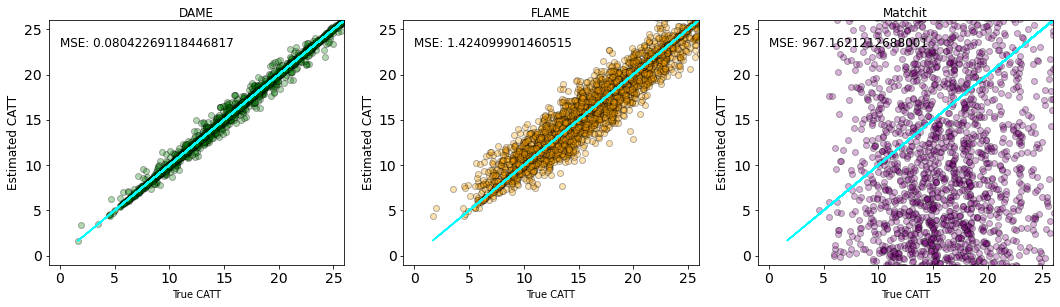

In [9]:
labelsize=16
ticksize = 14
f, axes = plt.subplots(1, 3, gridspec_kw = {'width_ratios':[1, 1, 1]}, figsize=(18,4.5))

def draw_scatter(ax, x, y, title, color, mse):
    ax.scatter(x, y, c = color, alpha = 0.3, marker = 'o', edgecolor = 'black') # plotting t, a separately 
    ax.plot(x,x, c = 'cyan') # plotting t, a separately 
    ax.set_xticks(range(0, 26, 5))
    ax.set_title(title, pad = 0.2, wrap = True, fontsize=labelsize*.75)
    ax.set_xlim(-1, 26)
    ax.set_ylim(-1, 26)
    ax.tick_params(labelsize=ticksize)
    ax.set_yticks(range(0, 26, 5))
    ax.set_ylabel("Estimated CATT", fontsize = labelsize*.75)
    ax.text(0, 23, "MSE: {}".format(mse), fontsize=labelsize*.75)
    ax.set_xlabel('True CATT')


draw_scatter(axes[0], true_catt_dame, estimated_catt_dame, "DAME",  "green", mean_squared_error(true_catt_dame, estimated_catt_dame))
draw_scatter(axes[1], true_catt_flame, estimated_catt_flame, "FLAME",  "orange", mean_squared_error(true_catt_flame, estimated_catt_flame))
draw_scatter(axes[2], true_catt, estimated_att_matchit, "Matchit",  "purple", mean_squared_error(true_catt, estimated_att_matchit))

From this graph, we see that the estimated CATT of matched units is substantially more accurate from matches generated by the `DAME-FLAME` package than by matches generated from propensity score matching from MatchIt's nearest neighbor match on a logit distance funciton. 